In [50]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10) # pre-setting seed
from scipy import stats
from scipy.stats import norm, chi2, f
# Numpy version matters for scipy

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split





# Boruta
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

# Heteroskedasticity
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt

# Missing data imputation
from sklearn.impute import KNNImputer
from statsmodels.imputation import mice



UsageError: Cell magic `%%R` not found.


In [3]:
data = pd.read_csv("/Users/Tadeh/Desktop/clean_data.csv")

In [4]:
dep_var = "Leverage"
ind_vars = ["ROA", "Log_Total_Assets", "Tangibility",
          "Log_Market_to_Book", "Effective_Tax_Rate"]

In [5]:
y = data[dep_var]
x = data[ind_vars]

In [6]:
model = sm.OLS(y, x).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:               Leverage   R-squared (uncentered):                   0.593
Model:                            OLS   Adj. R-squared (uncentered):              0.592
Method:                 Least Squares   F-statistic:                              625.3
Date:                Thu, 30 Oct 2025   Prob (F-statistic):                        0.00
Time:                        17:45:07   Log-Likelihood:                          621.91
No. Observations:                2153   AIC:                                     -1234.
Df Residuals:                    2148   BIC:                                     -1205.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

# Linearity: Residuals vs. fitted values plots, RESET test for specification

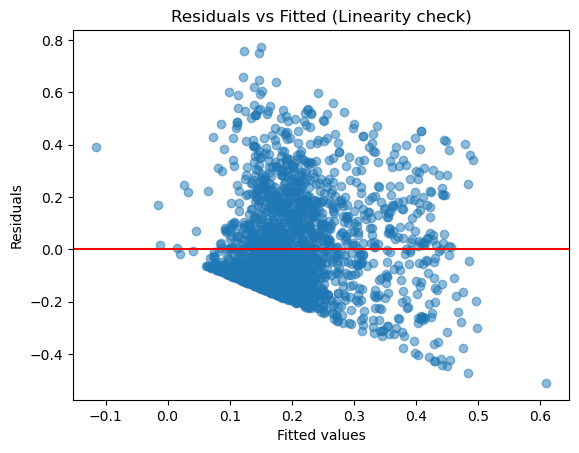

In [7]:
fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure
plt.scatter(fitted_vals, residuals, alpha=.5)
plt.axhline(y=0, color="red")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Linearity check)")
plt.show()

In [9]:
reset_test = linear_reset(model, power=2, use_f=True)
print("RESET test results (power=2):", reset_test)

RESET test results (power=2): <F test: F=0.0036455608349675876, p=0.9518598173798776, df_denom=2.15e+03, df_num=1>


# Homoskedasticity: Breusch-Pagan test, White test, scale-location plots

In [10]:
bp_test = het_breuschpagan(resid=model.resid, exog_het=sm.add_constant(x))

In [11]:
print(f'Test statistic: \t{bp_test[0]:.5f}\np-value: \t\t{bp_test[1]:.5f}')

Test statistic: 	58.88769
p-value: 		0.00000


In [12]:
white_test = het_white(resid=model.resid, exog=sm.add_constant(x))

In [13]:
print(f'Test statistic: \t{white_test[0]:.5f}\np-value: \t\t{white_test[1]:.5f}')

Test statistic: 	121.46839
p-value: 		0.00000


In [14]:
influence_std_resid = model.get_influence().resid_studentized_internal


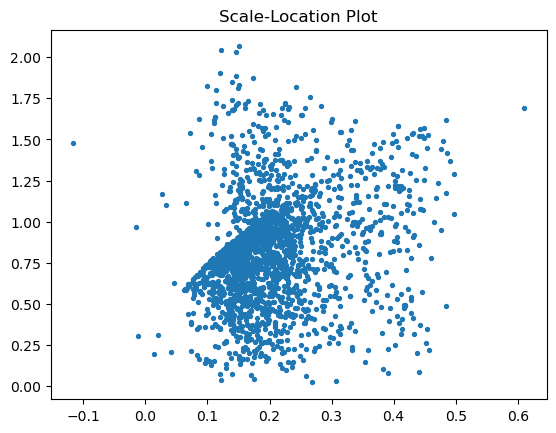

In [15]:
plt.figure
plt.scatter(x=model.fittedvalues, y=np.sqrt(np.abs(influence_std_resid)), s=8)
plt.title("Scale-Location Plot")
plt.show()

# Normality of residuals: Q-Q plots, Jarque-Bera test, histograms of residuals


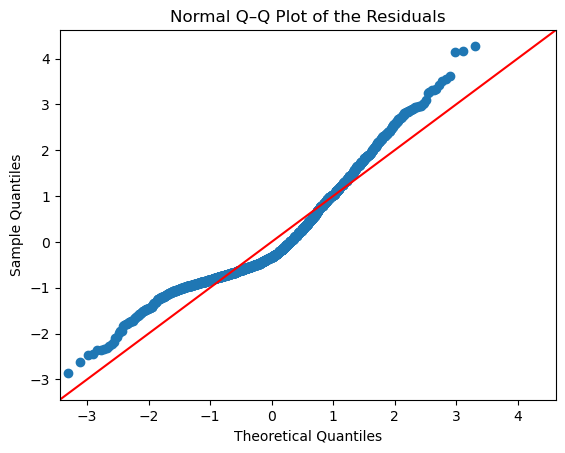

In [16]:
sm.qqplot(influence_std_resid, line = "45")
plt.title("Normal Q–Q Plot of the Residuals")
plt.show()

In [17]:
jb_test = sms.stattools.jarque_bera(influence_std_resid)
for p,q in zip(['JB', 'p-val', 'skew', 'kurt'], jb_test): print(f'{p}:\t {q:.4}')

JB:	 465.1
p-val:	 1.015e-101
skew:	 1.025
kurt:	 3.991


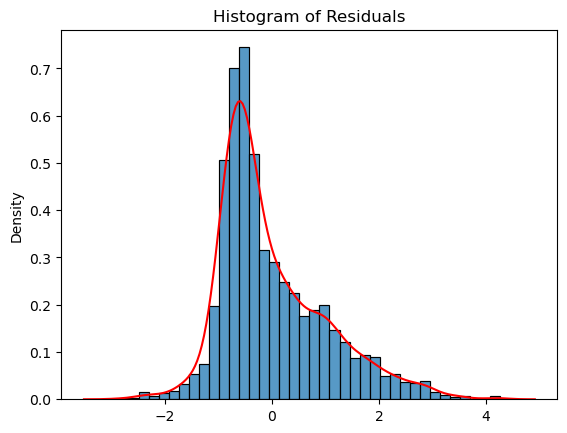

In [18]:
sns.histplot(influence_std_resid, stat='density')
sns.kdeplot(influence_std_resid, color='r')
plt.title('Histogram of Residuals')
plt.show()

# Outliers and influence: Cook’s distance plot, leverage vs. residuals, DFBETAS


In [25]:
#problems here, maybe someone with R can do it quickly



In [60]:
cooks = influence_std_resid.cooks_distance[0]
# We can also use the influence_plot() function to check for influential observations
figd, ax = plt.subplots(figsize=(12,8))

# The diameter of the circle is proportional to the Cook's Distance
figd = sm.graphics.influence_plot(model_log_influenced, ax = ax, criterion="Cooks")
figd.tight_layout(pad=1.0)

AttributeError: 'numpy.ndarray' object has no attribute 'cooks_distance'

# Robustness analysis: Bootstrap coefficient estimates (1000 replications), compare with OLS estimates


In [35]:
# Sample data
random.seed(90095)

# Function to fit model and output parameters
def fitted_OLS(x, y):
    # Here we'll use another way to fit an OLS model
    X = sm.add_constant(x)
    model = sm.OLS(endog=y, exog=X)
    fitted = model.fit()

    return fitted

# Run bootstrap
n_iterations = 1000
bootstrap_results = np.zeros((n_iterations, 6))
bootstrap_sigma = []

for p in range(n_iterations):
    X_resampled, y_resampled = resample(transact_X, transact_Y)
    fitted = fitted_OLS(x=X_resampled, y=y_resampled)
    coefs = fitted.params
    sigma_hat = pd.Series(np.sqrt(fitted.mse_resid))
    bootstrap_results[p:] = pd.concat([coefs, sigma_hat]) # includes bootstrapped sigma hat


transact_bs = pd.DataFrame(bootstrap_results, columns=['intercept','t1', 't2', 'sigmaHat'])

# Summary statistics
transact_bs_summary = transact_bs.agg(['mean', 'std', 'median'], axis=0).T
transact_bs_summary['lower-95'] = transact_bs.apply(lambda x: np.quantile(x,0.025)) # 2.5% lower bound
transact_bs_summary['upper-95'] = transact_bs.apply(lambda x: np.quantile(x,0.975)) # 97.5% upper bound

transact_bs_summary

NameError: name 'transact_X' is not defined

# Model validation: 5-fold or 10-fold cross-validation, out-of-sample prediction accuracy. Document any violations of OLS assumptions and discuss implications for your results.

In [61]:
regr = LinearRegression()

In [62]:
regr.fit(x, y)
print("Coefficients:", regr.coef_)
print("Intercept:", regr.intercept_)

Coefficients: [-0.03414021  0.01226682  0.3456931   0.02532127  0.06515781]
Intercept: -0.13312603415682026


In [63]:
regr = linear_model.LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scores = cross_val_score(regr, x, y, cv=5, scoring='neg_root_mean_squared_error')
print('5-Fold CV RMSE Scores:', scores)

5-Fold CV RMSE Scores: [-0.17937334 -0.18278133 -0.17088483 -0.19499158 -0.1819789 ]
